# Apply a trained SRFlow model

## Reproduce using our Setup

- Use the ./setup.sh
- It install the all packages from the requirements.txt
- If this notebook does not work, copy the code to start it from setup.py
- The python interpreter should be '../myenv/bin/python3'

In [1]:
import sys
print(sys.executable) 

/data/data-science/rsong/SRFlow/.venv/bin/python


# Initialize

In [2]:
import natsort, glob, pickle, torch
from collections import OrderedDict
import numpy as np
import os

import options.options as option
from models import create_model
from imresize import imresize

import Measure

def find_files(wildcard): return natsort.natsorted(glob.glob(wildcard, recursive=True))

from PIL import Image
def imshow(array):
    display(Image.fromarray(array))

from test import load_model, fiFindByWildcard, imread

def pickleRead(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [3]:
# Convert to tensor
def t(array): return torch.Tensor(np.expand_dims(array.transpose([2, 0, 1]), axis=0).astype(np.float32)) / 255

# convert to image
def rgb(t): return (np.clip((t[0] if len(t.shape) == 4 else t).detach().cpu().numpy().transpose([1, 2, 0]), 0, 1) * 255).astype(np.uint8)

# List model files

If you do not see models here, download them as in `setup.sh`.

In [4]:
find_files("../pretrained_models/*.pth")

['../pretrained_models/ESRGAN_DF2K_8X.pth',
 '../pretrained_models/RRDB_CelebA_8X.pth',
 '../pretrained_models/RRDB_DF2K_4X.pth',
 '../pretrained_models/RRDB_DF2K_8X.pth',
 '../pretrained_models/SRFlow_CelebA_8X.pth',
 '../pretrained_models/SRFlow_DF2K_4X.pth',
 '../pretrained_models/SRFlow_DF2K_8X.pth']

# Configuration files


In [5]:
find_files("confs/*.yml")

['confs/RRDB_CelebA_8X.yml',
 'confs/RRDB_DF2K_4X.yml',
 'confs/RRDB_DF2K_8X.yml',
 'confs/SRFlow_CelebA_8X.yml',
 'confs/SRFlow_DF2K_4X.yml',
 'confs/SRFlow_DF2K_8X.yml']

# List dataset directories


In [6]:
find_files("../datasets/**/")

['../datasets/',
 '../datasets/celebA-validation-gt/',
 '../datasets/celebA-validation-x8/',
 '../datasets/div2k-validation-modcrop8-gt/',
 '../datasets/div2k-validation-modcrop8-x4/',
 '../datasets/div2k-validation-modcrop8-x8/']

In [7]:
conf_path = './confs/SRFlow_CelebA_8X.yml'

### Instancieate the Model

In [8]:
model, opt = load_model(conf_path)

OrderedDict([('manual_seed', 10), ('lr_G', 0.0005), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.5, 0.75, 0.9, 0.95]), ('lr_gamma', 0.5), ('niter', 200000), ('val_freq', 40000), ('lr_steps', [100000, 150000, 180000, 190000])])


### Find the png paths

In [9]:
lq_paths = fiFindByWildcard(os.path.join(opt['dataroot_LR'], '*.png'))
gt_paths = fiFindByWildcard(os.path.join(opt['dataroot_GT'], '*.png'))
print(lq_paths, gt_paths) # For CelebA we have just 1

['../datasets/celebA-validation-x8/example0.png'] ['../datasets/celebA-validation-gt/example0.png']


In [10]:
lqs = [imread(p) for p in lq_paths]
gts = [imread(p) for p in gt_paths]


First LR image


First HR image


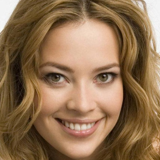

In [11]:
print("First LR image")
imshow(lqs[0])

print("First HR image")
imshow(gts[0])

# Super-Resolve using SRFlow for multiple temperatures

In [12]:
measure = Measure.Measure()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/data-science/rsong/SRFlow/.venv/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


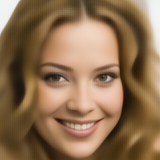

Temperature: 0.00 - PSNR: 26.4, SSIM: 0.8, LPIPS: 0.24




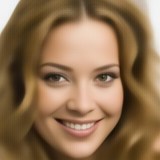

Temperature: 0.10 - PSNR: 26.3, SSIM: 0.7, LPIPS: 0.23




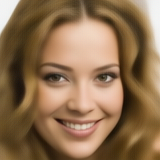

Temperature: 0.20 - PSNR: 26.3, SSIM: 0.7, LPIPS: 0.21




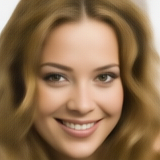

Temperature: 0.30 - PSNR: 26.2, SSIM: 0.7, LPIPS: 0.18




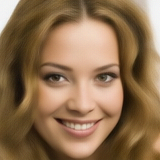

Temperature: 0.40 - PSNR: 26.1, SSIM: 0.7, LPIPS: 0.16




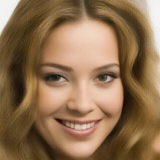

Temperature: 0.50 - PSNR: 25.8, SSIM: 0.7, LPIPS: 0.12




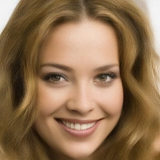

Temperature: 0.60 - PSNR: 25.4, SSIM: 0.7, LPIPS: 0.10




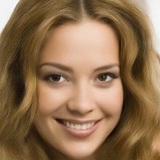

Temperature: 0.70 - PSNR: 25.3, SSIM: 0.7, LPIPS: 0.09




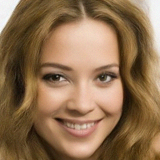

Temperature: 0.80 - PSNR: 24.8, SSIM: 0.7, LPIPS: 0.09




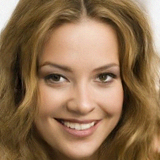

Temperature: 0.90 - PSNR: 24.3, SSIM: 0.7, LPIPS: 0.07




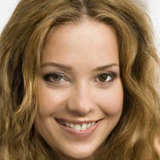

Temperature: 1.00 - PSNR: 23.8, SSIM: 0.6, LPIPS: 0.07




In [13]:
lq = lqs[0]
gt = gts[0]

for temperature in np.linspace(0, 1, num=11):
    # Sample a super-resolution for a low-resolution image
    sr = rgb(model.get_sr(lq=t(lq), heat=temperature))
    imshow(sr)
    psnr, ssim, lpips = measure.measure(sr, gt)
    print('Temperature: {:0.2f} - PSNR: {:0.1f}, SSIM: {:0.1f}, LPIPS: {:0.2f}\n\n'.format(temperature, psnr, ssim, lpips))


# LR Consistency

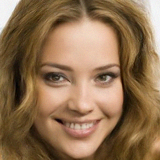

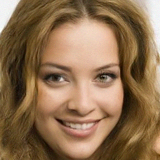

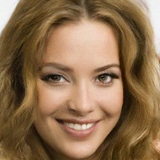

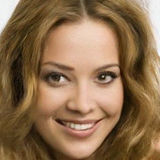

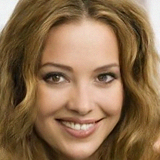

In [14]:
lq = lqs[0]
gt = gts[0]

temperature = 0.9

downsampled = lq
for idx in range(5):
    sr = rgb(model.get_sr(lq=t(downsampled), heat=temperature))
    downsampled = imresize(sr, 1/8)
    
    imshow(sr)
